## Table of Contents:
1. [Introduction](#1)
1. [Detecting Bots with Random Forest Machine Learning](#2)
1. [Building Twitter Bots](#3)
1. [Data Retrevial](#4)
1. [Results & Conclusion](#5)
1. [Appendix](#6)
1. [References](#7)

<a id="1"></a>
# 1. Introduction
This project aims to create a Twitter bot that cannot be detected by commonplace bot detection algorithms as well as provide an elementary overview of Random Forest machine learning and its implementation. We first introduce Random Forest machine learning and illustrate how it can be used to classify Twitter accounts as either bots or ordinary users. Next we create two bots. We build the first (smarter) bot on a Long Short-Term Memory neural network in an attempt to evade detection by the Random Forest algorithm. The second is a bot similar to traditional bots on Twitter as a control subject with simple, favoriting, retweeting and following mechanisms. We then illustrate how to retrieve the publicly available data from the Twitter API for each of the respective bots. Lastly, we run this data through the Random Forest bot detection algorithm in order to ascertain whether either are categorized as a bot. 

<a id="2"></a>
# 2. Detecting Bots with Random Forest Machine Learning


## 2.1 Random Forest
Random Forests are machine learning algorithms which create a multitude of decision trees and find a democratically determined result. There are essentially two kinds of Random Forest algorithms: classification algorithms and regression algorithms. Classification machine learning algorithms attempt to identify which set of sub-categories a certain observation belongs to. On the other hand, regression algorithms estimate the relationship between variables. For our purposes, the classification Random Forest type is the best suited for classifying whether a given Twitter account is a bot. 

We do not address the inner workings of Random Forest algorithms (for how a Random Forest algorithm is created [here](https://enlight.nyc/projects/random-forest/)), but instead cover how Random Forests operate in principle and how they are trained. Random Forests are comprised of multiple decision tress. A single decision tree is very weak in that it is not flexible in predictions of new data. As quoted from the *The Elements of Statistical Learning*, "Trees have one aspect prevents them from being the ideal tool for predictive learning, nameley inaccuracy" (Hasite, Tibshirani, Friedman; 2001). The strength of the predictive power of Random Forest comes from the shear number of decision trees and the random nature of how they are made. Bellow is an image of a single randomly generated decision tree taken from our Random Forest. 

<a id="fig1"></a>
<img src="bot_tree_example.png">
<center>*Figure 1: Example of decision tree from Random Forest.*</center>

A decision tree is formed first around a root node which attaches to various internal nodes. These internal nodes are attached to other root nodes until the result in what is known as a leaf node. These leaf nodes are where the result is determined. We address how these trees are generated [later in the notebook](#tree_creation).


## 2.2 Creating a Random Forest

### 2.2.1 Importing & Preparing Data

To train a Random Forest algorithm, we require a dataset of historical data which includes the independent variables we want to consider (colloquially known as features), as well as the dependent variable––i.e. the outcome we want to predict (known as labels). In our case the features include all numerical or boolean data publicaly provided by Twitter for a given account and the labels include whether the account is a known bot or not. To do this we import the data of `'bot_or_not_data.csv'` containing all public information on a number of accounts as well as information as to whether the account is a bot.

In [1]:
# importing necesary libraries
import os
import numpy as np
import pandas as pd

#importing training data
data = pd.read_csv('bot_or_not_data.csv')
data.head(5)

,screen name,followers,friends,statuses count,favourites,location,default profile image,language,created at,verified,text,bot
0,aaroncarter,571310,76070,56077,37437,Sony Recording Artist,False,en,Thu Apr 23 20:15:49 +0000 2009,True,"{u'contributors': None, u'truncated': False, u...",0
1,michellebranch,292385,963,16688,1248,NaN,False,en,Fri Mar 30 20:58:59 +0000 2007,True,"{u'contributors': None, u'truncated': False, u...",0
2,stronginmyfaith,1,7,3,0,NaN,True,en,7/13/2009 0:38,False,"Status(contributors=None, truncated=False, tex...",0
3,Jessicaveronica,222659,352,10999,143,5th Dimension,False,en,Tue Mar 31 21:12:33 +0000 2009,True,"{u'contributors': None, u'truncated': False, u...",0
4,resargento,646,446,25292,13440,brasil,False,pt,4/13/2012 17:37,False,NaN,0


After importing our data for training the Random Forest, we need to remove any reduntant data for our prediction (i.e. `location`, `language`, and `created at`). However, we tokenize the `screen name` column because Twitter bots occasionally countain the word "bot" in their screen. We also find how many retweets each account has made since bots often retweet without generating their own tweets. Lastly, we keep the `verified`, `default profile image` columns and change them from boolean data (True or False) to numerical data for the Random Forest to interperet. 

We create the bellow function to change all True values into 1s, and all False values into 0s. It also assigns a value of 1 to all accounts which contain bot in its name, and finds how many retweets the account has made and creates a new column to store these values named `retweets`.

In [2]:
# if bot in name replace with 1 or 0
data['screen name'] = np.where(data['screen name'].str.contains('bot'),1,0)

# weighting number of retweets per account and assigning value to new index column
number_retweets = (data["text"].str.find('retweet')+1) + (data["text"].str.find('RT @')+1)
data["retweets"] = number_retweets/1000

# removing non-numerical data & converting booleans to 1s & 0s
for column in data:
    if np.issubdtype(data[str(column)].dtype, np.dtype(bool)) == True:
        data[column]*=1
    elif np.issubdtype(data[str(column)].dtype, np.number) == False:
        data = data.drop(str(column), axis = 1)

# removing NaNs
data = data.fillna(0)        

# finding the shape of the dataset
print('The shape of the data is:', data.shape)

The shape of the data is: (2232, 9)


Now that our data has been formatted for our Random Forest, we isolate the label (here the `bot` column) and convert it into a numpy array. We then remove the column from the data and also convert the data into a numpy array. 

In [3]:
# labels are what we want to predict with random forest (in this case whether bot or not)
labels = np.array(data['bot'])

# removing the 'bot' column from the dataset
data = data.drop('bot', axis = 1)

# saving column names for later use in data_list
data_list = list(data.columns)

# converting into numpy array
data = np.array(data)

### 2.2.2. Bootstrapping and Training the Random Forest
Now that our cell is prepared for implementation, we import `test_train_split` from the sklearn library. This will help us to created a bootstapped dataset which will be used to train the data. The bootstrapped dataset is created by randomly selecting accounts (rows) from the dataset and compiling them into a new dataset. When randomly selecting subjects, we also allow for a specific row to be chosen repeatedly. The paramter`test_size = .3` implies that 70% of our data will be used in the bootstapped dataset and 30% will be ignored for later testing of the Random Forest.  We then assign training data and labels and testing data and labels.

In [4]:
# importing  train_test_split in order to create a bootstraped dataset
from sklearn.model_selection import train_test_split

# spliting the data into training data and testing data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = .3, random_state = 101)

# displaying the shapes of the partiotined training sets and testing sets
print('Training Data Shape:', train_data.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Data Shape:', test_data.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Data Shape: (1562, 8)
Training Labels Shape: (1562,)
Testing Data Shape: (670, 8)
Testing Labels Shape: (670,)


<a id="tree_creation"></a>

Now that we have created our bootstrapped dataset, we import `RandomForestClassifier`. With this we decide our Random Forest will be comprised of 1000 randomly generated decision trees. `rf.fit()` then trains our Random Forest with the assigned training data and labels.
To create the first decision tree, the algorithm randomly selects only two features (columns) to determine the root node of the tree. The algorithm then compares the results of the subset of features and whichever was superior in determining the correct outcome is assigned to the root node. This same procedure is repeated with the internal nodes while disregarding the features which have already been assigned until all features have been considered. The algorithm repeats this process to create hundreds to thousands of unique trees.

<img src="tree_explanation.png" width = 500>
<center>*Figure 2: Explanation of decision tree creation with Random Forest*</center>

In [5]:
# import random forest
from sklearn.ensemble import RandomForestClassifier

# setting random forest parameters
global rf
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)

# fitting the random forest with the training data and training labels
rf.fit(train_data, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

### 2.1.3 Accuracy & Predicting Outcomes
Now that we have a functional Random Forest, we need to check how accurately it predicts whether a given account is a bot or not.  We test accuracy of our Random Forest by using out-of-bag data set (the portion of data left out of the bootstrapped dataset) and predicting outcomes for its given features. We then compare the difference between the predicted labels and the actual labels to find how accurate our Random Forrest is. We take data with variables (features) identical to those used in the bootstrapped dataset and run it to predict out dependent variable (label) for a given account with `rf.predict()`. The function runs the data through each of the decision trees and records whether it ended in a bot node or a not-a-bot node. The algorithm, then records this result for every decision tree in the Random Forest. Finally, the algorithm tallies the about of bot results and the number of not-a-bot results. Whichever state received the most positive results is then the final result for that account. It does this for every account and creates an array of predicted states (bot/not-a-bot). We then take the absolute value of the difference between the predicted labels and the actual labels to find the mean absolute error of our prediction. 

In [6]:
# using out-of-bag test data to test accuracy of predictions
predictions = rf.predict(test_data)


# finding mean sbsolute error
errors = abs(predictions - test_labels)
print("Mean absolute error:", round(np.mean(errors), 4), 'degrees')

# finding accuracy or predictions as percentage
accuracy = (sum(predictions)/sum(test_labels))*100
print('Accuracy of random forest prediction:', round(accuracy, 4),'%')

Mean absolute error: 0.0791 degrees
Accuracy of random forest prediction: 95.2077 %


This result implies that our Random Forest determines whether a given account is a bot or not with 95.21% accuracy. This was the highest degree of accuracy we were able to achieve with any specific variables and parameter settings. Bellow, we show the receiver operating characteristic (ROC) curve for our Random Forest which plots the true positive rate against the false positive rate. The blue line shows perfect accuracy of comparing the training data with itself, and the red dotted line represents the prediction of our Random Forest. 

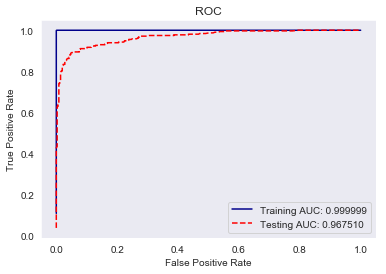

In [8]:
# importing further libraries for accuracy visualization
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import roc_curve, auc

# creating probability scores for training and test data
scores_train = rf.predict_proba(train_data)
scores_test = rf.predict_proba(test_data)

train_label_scores = []
test_label_scores = []
for i in range(len(scores_train)):
    train_label_scores.append(scores_train[i][1])

for i in range(len(scores_test)):
    test_label_scores.append(scores_test[i][1])
    
fpr_rf_train, tpr_rf_train, _ = roc_curve(train_labels, train_label_scores, pos_label=1)
fpr_rf_test, tpr_rf_test, _ = roc_curve(test_labels, test_label_scores, pos_label=1)

# plotting lines and creating legend
plt.plot(fpr_rf_train, tpr_rf_train, color='darkblue', label='Training AUC: %5f' %auc(fpr_rf_train, tpr_rf_train))
plt.plot(fpr_rf_test, tpr_rf_test, color='red', ls='--', label='Testing AUC: %5f' %auc(fpr_rf_test, tpr_rf_test))

# setting graphic style, labels & axes
sb.set_style("darkgrid", {'axes.grid' : False})
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

The next step in fine tuning a machine learning algorithm is generally to find the most important variables which contributed to our result. In the case of out Random Forest, we find that the most important variable for the Random Forest's bot detection is the number of accounts it is following, then the number of accounts that are following it, followed by the number of posts it has made etc. This exemplifies how the Random Forest works. 

For example, a human would logically be able to associate the verified status of an account with the fact that it likely is not a bot.  The Random Forest however, cannot comprehend the significance of account verification and assigns it as a less important determinant of bot detection because of how few verified accounts there were in the training dataset (which is also representative of the minority of verified accounts on Twitter itself). The Random Forest does pick up on the fact that bots follow a much larger number of accounts than real users. This makes logical sense as very few real people are interested in following hundreds or thousands of accounts. Whereas bots follow a large number of accounts to increase their own following.

Variable: friends                                  Importance: 0.27
Variable: followers                                Importance: 0.21
Variable: favourites                               Importance: 0.17
Variable: statuses count                           Importance: 0.13
Variable: verified                                 Importance: 0.1
Variable: retweets                                 Importance: 0.1
Variable: screen name                              Importance: 0.01
Variable: default profile image                    Importance: 0.01


Text(0.5,1,'Cumulative Importance')

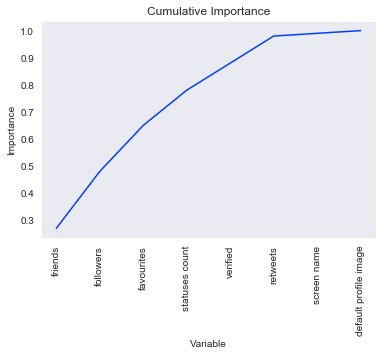

In [83]:
# finding the importance of features
importances = list(rf.feature_importances_)
variable_importances = [(data, round(importance, 2)) for data, importance in zip(data_list, importances)]
variable_importances = sorted(variable_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:40} Importance: {}'.format(*pair)) for pair in variable_importances]

# creating a sorted list of variables 
sorted_importances = [importance[1] for importance in variable_importances]
sorted_variables = [importance[0] for importance in variable_importances]

# list of x locations for plotting
x_values = list(range(len(importances)))

# making a cumulative ditribution of importance by variable
cumulative_importances = np.cumsum(sorted_importances)
plt.plot(x_values, cumulative_importances)
plt.xticks(x_values, sorted_variables, rotation = 'vertical')

# axis labels, style and title
plt.style.use('seaborn-bright')
plt.xlabel('Variable')
plt.ylabel('Importance')
plt.title('Cumulative Importance')

Next, we run the Random Forest with only the most instrumental variables to see if we can improve its accuracy. However, in the case of our Random Forest for predicting whether a Twitter account is a bot, we found that using any particular subset of the variables lead to a loss in accuracy and therefore continued with all our variables in the Random Forest. 

<a id="3"></a>
# 3. Building Twitter Bots

In this part of the project, we create two bots that will be tested by random forest later on. Our goal is to create a smart bot and a dummy one. The reason for creating two bots is that it allows to show that, despite being the most common technique to detect bots, random forest may fail sometimes. Let's start with the most interesting bot, the smart one and then go over the dummy one.

## 3.1. Creating a (Smart) Bot with LTSM Neural Networks

To defeat the Random Forest algorithm, we create a bot that go over tweets containing the strings sequence "bot" and retweet, favorite and follow the author. In other words, if the bot detects a tweet where the word "bot" appears, it will retweet the tweet, favorite it and follow the author of the tweet. We decide to limit the retweet, follow and favorite operations to 100 times every 15 seconds.

The choice of the strings sequence "bot" is not accidental. We know that the random forest algorithm uses the number of followers as a predictor in bot detection. By following twitter bot accounts, we hope that they follow us back, since they have likely been programmed to do so. By following us back, they then reduce the probability that we get detected as a bot by random forest.

In [9]:
import tweepy
from credentials import *
from time import sleep

# connecting to Twitter
consumer_key = 'Bzl0fpbpA3I5o8aEVZQywhFw0'
consumer_secret = 'QS0V6HMwamnKCTiwVRpydaViLIS5gnlcN0vbH2c3ttjnqTv9M0'
access_token = '1070059672932093952-XuQAIEAquqnbZdTXXoEgDsfNAt4pnh'
access_token_secret = 'DP7ip3qX7cDBXExXqqNMtRmw2smr14Ej591Yze7oA2MU5'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

# retweet, favorite and follow some tweets containing the strings sequence "bot"
for tweet in tweepy.Cursor(api.search, 'bot').items(0): # will retweet, favorite and follow 30 times
    
    # retweet every 15 seconds
    try:
        tweet.retweet()
        sleep(15)
    except Exception as error:
        print('Could not retweet because',error)
    sleep(15)
    
    # favorite every 15 seconds
    try:
        tweet.favorite()
    except Exception as error:
        print('Could not favorite because',error)
    sleep(15)
   
    # if cannot favorite, return error
    try:
        api.create_friendship(tweet.author.screen_name)
        print(tweet.author.screen_name)
    except Exception as error:
        print('Could not favorite because',error)
        
    try:
        for follower in tweepy.Cursor(api.followers).items():
            follower.follow()
    except Exception as error:
        print('Could not follow because',error)       

fuurisu_bot
xxAKBxx_seven
sportsword_bot
KatekyoMyj_bot
vcdgrra_bot
yxxx_bot
irairamax_bot
cielo_de_bot


KeyboardInterrupt: 

Adding complexity to our twitter account reduces the probability of being detected. For instance, if our bot is capable of tweeting its own tweets instead of simply retweeting, the liklihood of detection by a classification algorithm like Random Forsest decreases. In this regard, we use Long Short-Term Memory neural networks (LSTM) as a basis for the text generation process. Unlike other classical neural networks, LSTM is a powerful tool in text generation because it is able to connect previous information to the present task. In fact, the model is built with loops in it allowing information to persist. For tweets generation and faking human behavior, we believe that this characteristic plays an important role. For further details about LSTM, [here](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is a useful article.

In [ ]:
# load LSTM network
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

filename = "utilitarist.txt"

# only lower characters to facilitate implementation
raw_text = open(filename).read().lower()
chars = sorted(list(set(raw_text)))

# create mapping of unique chars to integers
char_to_int = dict((c, i) for i, c in enumerate(chars))
n_chars = len(raw_text)
n_vocab = len(chars)
seq_length = 140

dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
    seq_in = raw_text[i:i + seq_length]# selecting characters through indexing
    seq_out = raw_text[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])# converting characters to integers
    dataY.append(char_to_int[seq_out])

Around 48,000 patterns that will be propagated through the network. We reshape the input data and normalize the values by which the neural network can be easily trained. The LSTM model that we use has a total of 2 layers of neurons and its performance is measured via the cross-entropy loss function. It is important to note that our goal is not to generate meaningful texts with the network, but to create a bot which can post on its own. Posting meaningful tweets would require an enormous number of epochs as well as a dozens of hidden layers. One epoch is when an entire dataset is passed forward and backward through the neural network. And as we is shown by our Random Forest detectiion algorithm––as well as other detection algorithms––the content of the tweet has a miniscule influence on detectibility by classification machine learning. 

Due to the intense computational power and the long training time, we decide to fix the number of epochs to 10. Since one epoch is too big to feed to the computer at once we divide it into several smaller batches. As you can see in line 6 of the following cell, the batch size is 256. This means that the algorithm proceeds to select every 256th character for trainig. We use the dropout as regularization technique to avoid overfitting. Learn more about it [here](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/). For the time spared, we lose in the accuracy of the output. The texts generated do not often make sense at all, but some words are occasionally recognizable. For the purpose of tweet generations, the current accuracy of our algorithm should suffice for successfully evading detection. 

The network is activated with softmax function which maps the values of the input vectors to a certain probability of occurrence. For example, the letter "t" is more common in the english than the letter "z". Hence, the probability that the character "t" is generated by the network is higher. Perhaps the letter "h" is the most probable outcome after the first letter predicted was "t". Hence, the network will probably generate "h" after having generated "t". Finally, the algorithm might understand that "e" is the most common letter after "th" and hence likely predicts "e". In the end, the final output predicted by the network might be "the".

In [ ]:
n_patterns = len(dataX)
X = np.reshape(dataX, (n_patterns, seq_length, 1))/ float(n_vocab)# reshape X to be [samples, time steps, features] and normalize
y = np_utils.to_categorical(dataY)# one hot encode the output variable

# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

The code in the cell bellow trains the LTSM. It does this by using the data to create conclusions as to why certian letters occur where they do. These conclusions are what enable the LTSM neural networks to generate its own text. We recomend you <span style="color:red">**DO NOT RUN THIS LINE OF CODE**</span> as it takes on average **170 minutes** to train the neural network.

In [ ]:
# model.fit(X, y, epochs=10, batch_size=256, callbacks=callbacks_list)

In the proceeding section, we upload the hdf5 file in which the neural network has performed best.

In [ ]:
# create mapping of unique chars to integers, and a reverse mapping
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))

# summarize the loaded data
n_chars = len(raw_text)
n_vocab = len(chars)

# prepare the dataset of input to output pairs encoded as integers
seq_length = 140
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
    seq_in = raw_text[i:i + seq_length]
    seq_out = raw_text[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)

# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, seq_length, 1))

# normalize
X = X / float(n_vocab)

# one-hot encode the output variable
y = np_utils.to_categorical(dataY)

# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))

# load the network weights
filename = "weights-improvement-10-2.5246.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# pick a random seed
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]

# generate characters
for i in range(100):
    x = np.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model.predict(x, verbose=0)
    index = np.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    sys.stdout.write(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]

After exstensive training, the text generation is impressively disappointing for the ammount of time and computational effort required. We assume that the inaccuracy is due to an insufficient training time of the network, too small a number of layers and an overly large big batch size. In the coming part, we implement the code that will automatically generate tweets based on the neural network output. 

In [ ]:
# importing Twython in order to upload Tweets
from twython import Twython

# connecting to Twitter
consumer_key = 'Bzl0fpbpA3I5o8aEVZQywhFw0'
consumer_secret = 'QS0V6HMwamnKCTiwVRpydaViLIS5gnlcN0vbH2c3ttjnqTv9M0'
access_token = '1070059672932093952-XuQAIEAquqnbZdTXXoEgDsfNAt4pnh'
access_token_secret = 'DP7ip3qX7cDBXExXqqNMtRmw2smr14Ej591Yze7oA2MU5'

# determining number of genratred tweets
n=input(int())
print('number of tweets generated:', n)


for tweets in range(0,int(n)):
    try:
        for i in range(100): # generate 100 characters 
            x = np.reshape(pattern, (1, len(pattern), 1))/ float(n_vocab)
            prediction = model.predict(x, verbose=0)
            index = np.argmax(prediction)
            result = int_to_char[index]
            seq_in = [int_to_char[value] for value in pattern]
            pattern.append(index)
            pattern = pattern[1:len(pattern)]

        message= ' '.join(seq_in)
        
        # authentification of account characteristics
        twitter = Twython(
            consumer_key,
            consumer_secret,
            access_token,
            access_token_secret)
        twitter.update_status(status=message)
        
    except Exception as error: # if not able to tweet, define error
        print('Could not tweet because',error)

The redundancy of the text generation process causes problems. Indeed Twitter does not accept duplicated tweets. Despite that, our bot has made some tweets. Here are some of them:

<img src='tweets.png' width=500>
<center>*Figure 3: Exhibit of hsg ninja's tweets*</center>

Thanks to the ability to retweet, tweet, like, and follow, our bot should be undetected by Random Forest. The link to our smart bot's Twitter account can be found [here](https://twitter.com/hsg_ninja).

## 3.2. Creating a Dummy Bot
Now that we have created our smart bot, we must create our dummy bot as a control. The purpose of the dummy bot is to show that without text creation and smart retweets, there is a higher likelihood of being detected. The bot uses mostly the same code as the smart bot however it does not generate its own tweets and follows significantly more accounts. It simply follows, retweets, and likes other tweets. Here is the code:

In [ ]:
# connect to Twitter
consumer_key = 'S55A6RTOfFU2qX3jHePZfACwc'
consumer_secret = 'vYWc99on2ITuzctw3FCsKpwvF62QZuLP6xK9h7d7yt1VOllVAy'
access_token = '1088145790571368481-jUXOGRVDAmbU7Ns5cO97fRT1nTOXfm'
access_token_secret = 'X7bKw8nJNTsGlWuRqwdt8KiAfFSJAlhxsjBFYRxsHBZPQ'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

# retweet, favorite and follow some tweets containing the strings sequence "barcelona"
for tweet in tweepy.Cursor(api.search, 'barcelona').items(100):#will retweet, favorite and follow 30 times.
    try:
        tweet.retweet()
        sleep(15) # retweet every 15 seconds
    except Exception as error:
        print('Could not retweet because',error)
    sleep(15)
    try:
        tweet.favorite()
    except Exception as error:
        print('Could not favorite because',error)
    sleep(15) # favorite every 15 seconds
    try:
        api.create_friendship(tweet.author.screen_name)
        print(tweet.author.screen_name)
    except Exception as error:
        print('Could not favorite because',error)
        
    try:
        for follower in tweepy.Cursor(api.followers).items():
            follower.follow()
    except Exception as error:
        print('Could not follow because',error)

The consumer key and access token are different since we are connecting to another account. The key word is no longer "bot", but "barcelona". The dummy bot will therefore retweet and like any tweet containing the word "barcelona" every 15 seconds and will also follow the author of those tweets. When the bot reaches the limit of 100 tweets, it will stop. Here is how it looks on Twitter:

<img src='retweet.png' width=500>
<center>*Figure 4: Example of retweet and like based on traget word "Barcelona"*</center>

You can take a look at the bot [here](https://twitter.com/hsg_dummy)

<a id="4"></a>
# 4. Data Retrieval 

Now that our two bots have done their job on Twitter, we need to get their data to test them with the Random Forest algorithm.

In [17]:
import csv

# consumer keys and access tokens, used for OAuth
consumer_key ='rwIGfpm2zAHHJlUk3CB3P3joU'
consumer_secret ='MXD9Oj1BroVtfhTEv4DoyXEgtnyDwKR4qv012Yr4we6SyXBgdl'
access_token ='351845855-DYjD5t8wKcJHaAXbPdQInfNrsrThr74QiQ4WxpUX'
access_secret ='tnu4CQvyK4bq6gcoDy7N6SXiHBelJNDo4Oah3ZN6bV3A7'

 
# OAuth process, using the keys and tokens and creation of an interface using the authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth)

def download_data(user_target):
    # target the twitter user that we want to get data from
    user = api.get_user(str(user_target))

    # create a csv file and retrieve all necessary data through the api with 'user'
    fieldnames = ["screen name","followers","friends","statuses count","favourites", "location", "default profile image", "language","text", "created at", "verified", "bot"]
    with open(user_target+'.csv', mode='w') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames)
        writer.writeheader()
        writer.writerow({"screen name" : user.name,"followers" : user.followers_count,"friends" : user.friends_count,"statuses count" : user.statuses_count,"favourites" : user.favourites_count, "location" : user.location, "default profile image" : user.default_profile_image, "language" : user.lang, "text": np.nan, "created at" : user.created_at, "verified" : user.verified, "bot":np.nan})

    # display the data that has been collected
    display(pd.read_csv(user_target + '.csv', index_col  ="screen name"))

download_data('hsg_ninja')
download_data('hsg_dummy')

,followers,friends,statuses count,favourites,location,default profile image,language,text,created at,verified,bot
screen name,,,,,,,,,,,
hsg ninja,36,115,116,111,NaN,True,en,NaN,2018-12-04 20:58:01,False,NaN


,followers,friends,statuses count,favourites,location,default profile image,language,text,created at,verified,bot
screen name,,,,,,,,,,,
hsg_dummy,4,93,99,99,St. Gallen,True,en,NaN,2019-01-23 18:45:48,False,NaN


The above cell is using the Twitter API to grab the data of a targeted user. Here, we target our dummy bot called "hsg dummy". We use the method api.get_user to return the information of our specific user. We then create a csv file where we name the different columns and use a dictionary to link the columns to specific orders made to the api. For example, we attribute the function user.name to the string "screen name". 

In the end, we display the data that has been saved into the csv file thanks to Pandas.

To make the difference between the two bots that we have just created, we must differentiate tweets and retweets. There is no proper way to get the number of tweets and the number of retweets via the Twitter API. As one can see in the display of our bot "hsg dummy" above, we only get the statuses count. It is the sum of tweet of retweets.

In [18]:
def retrieve_tweets(screen_name):
    all_tweets = []
    new_tweets = api.user_timeline(screen_name, count=200)
    all_tweets.extend(new_tweets)
    oldest = all_tweets[-1].id - 1

    while len(new_tweets) > 0:
        new_tweets = api.user_timeline(screen_name = screen_name, count=200, max_id=oldest)
        all_tweets.extend(new_tweets)
        oldest = all_tweets[-1].id - 1
        print("...{} of {}'s tweets have been downloaded".format(len(all_tweets),screen_name))

    data = [item.text.encode('utf8') for item in all_tweets]
    df = pd.DataFrame(data, columns = ['tweet'])
    df.to_csv(screen_name + '_tweets.csv', index=False)

retrieve_tweets('hsg_ninja')
retrieve_tweets('hsg_dummy')

...116 of hsg_ninja's tweets have been downloaded
...98 of hsg_dummy's tweets have been downloaded


In the function above, we go trough the timeline of one of our smart bot. Thanks to that, we get all the tweets and retweets in a written format. The limit of tweet, that we save into a csv file, is set at 200. Therefore, we can get the entire timeline.

<a id="5"></a>
# 5. Results & Conclusion
Now that we have imported the necessary data from Twitter's API, we can test whether our boot can be detected by the Random Forest algorithm. We first add the tweets to the dataset and use the `bot_test` function to organize the data and subsequently use our `rf.predict()` function to predict an outcome of either 1 or 0. 1 implying that our bot was indeed predicted to be a bot and 0 implying that it went undetected. 

In [20]:
def bot_test(file):
    data = pd.read_csv(str(file) + '.csv')
    tweets = pd.read_csv(str(file) + '_tweets.csv')
    
    # adding tweets to text column of data file
    for entry in tweets['tweet']:
        data['text'] = entry
        
    # recording bot name
    bot_name = data.iloc[0,0]

    # if bot in name replace with 1 or 0
    data['screen name'] = np.where(data['screen name'].str.contains('bot'),1,0)

    # weighting number of retweets per account and assigning value to new index column
    number_retweets = (data["text"].str.find('retweet')+1) + (data["text"].str.find('RT @')+1)
    data["retweets"] = number_retweets/1000

    # removing non-numerical data & converting booleans to 1s & 0s
    for column in data:
        if np.issubdtype(data[str(column)].dtype, np.dtype(bool)) == True:
            data[column]*=1
        elif np.issubdtype(data[str(column)].dtype, np.number) == False:
            data = data.drop(str(column), axis = 1)

    # removing NaNs and bot column
    data = data.dropna(axis=1, how='all')

    # converting into array
    data = np.array(data)
        
    # testing the bot using the trained Random Forest
    bot_or_not = rf.predict(data)
    
    print('The Random Forest classified {} with {}'.format(bot_name, bot_or_not))
       
    if bot_or_not == 1:
        print('{} is a bot!'.format(bot_name))
    
    elif bot_or_not == 0:
        print('{} is not a bot.'.format(bot_name))
        
bot_test('hsg_dummy')   
bot_test('hsg_ninja')

The Random Forest classified hsg_dummy with [1]
hsg_dummy is a bot!
The Random Forest classified hsg ninja with [0]
hsg ninja is not a bot.


Ta dah! The Random Forest does not recognize the smart bot! However it was able to detect the more traditional bot which did not use LSTM machine learning. Despite Random Forest's strengths and ubiquitous implementation for bot detection, some bots can circumvent detection through similar machine learning models. To confirm this result, one can use this code to import data from any Twitter account using their Twitter handle (for example the bot "FTGMami_bot") with the `download_data` and `retrieve_tweets` functions. Then run it through the `bot_test` function to determine whether an account is a bot or not.


![These aren't the driods you are looking for](https://media.giphy.com/media/3o84sF21zQYacFcl68/giphy.gif)

<a id="6"></a>
# 6. Appendix
The code bellow was used to create the image of the single decision tree in [figure 1](#fig1) taken from our Random Forest Algorithm.

In [104]:
# VISUALISING SINGLE TREE FROM RANDOM FOREST
from sklearn.tree import export_graphviz
import pydot

# singling out a single tree from random forest
tree_ex = rf.estimators_[5]

# exporting the visiulization and creating a graph
export_graphviz(tree_ex, out_file = 'bot_tree_example.dot', feature_names = data_list, rounded = True, precision = 1)

(graph, ) = pydot.graph_from_dot_file('bot_tree_example.dot')

graph.write_png('bot_tree_example.png')

<a id="7"></a>
# 7. References
Hastie, T., Tibshirani, R., & Friedman, J. H. (2017). *The Elements of Statistical Learning: Data mining, inference, and prediction.* New York, NY, USA: Springer.

<center>Created by: Bryan Jacot-Descombes, Mike Sipofo, August Strotz</center>